# Stanford Car Classifier Model
Model ResNet34 is built with Fastai v1 and PyTorch v1 and trained on the Google Cloud Platform(GCP) with NVIDIA TESLA P100 GPU 16GB memory.  

The Stanford dataset Consists of 8144 Training Images and 8144 Testing images.

In [60]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [61]:
#Import Libraries
from fastai.vision import *
from fastai.metrics import error_rate
from scipy.io import loadmat
import pandas as pd

In [62]:
car_path = Path('/home/jupyter/.fastai/data/car')
car_train = Path(car_path/'cars_train')
car_test  = Path(car_path/'cars_test')
car_label = Path(car_path/'devkit')

In [63]:
#Transformation for Data Augmentation
arch = models.resnet34
arch_name = 'resnet34' #define string arch_name for saving the model
metric = [accuracy]
tfms = get_transforms()
size = 299
bs = 16

In [64]:
combine_lb_an = pd.read_csv('/home/jupyter/.fastai/data/car/combine_lb_an.csv')

In [65]:
train_df = combine_lb_an.loc[combine_lb_an['is_test'] == 0, ['filename', 'class_name', 'class_id']].copy()

In [66]:
train_df.head()

,filename,class_name,class_id
0,00001.jpg,Audi TTS Coupe 2012,14
1,00002.jpg,Acura TL Sedan 2012,3
2,00003.jpg,Dodge Dakota Club Cab 2007,91
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,134
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,106


In [67]:
train_df['class_name'].nunique(), train_df['filename'].nunique()

(196, 8144)

Create Databrunch for the training dataset

In [68]:
data = (
    ImageList.from_df(df=train_df, path=car_train)
    .split_by_rand_pct(valid_pct=.2, seed=1010)
    .label_from_df(cols='class_name')
    .transform(tfms=tfms, size=size)
    .databunch(bs=bs)
)

In [69]:
data

ImageDataBunch;

Train: LabelList (6516 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: /home/jupyter/.fastai/data/car/cars_train;

Valid: LabelList (1628 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Nissan 240SX Coupe 1998,Audi S5 Convertible 2012,Chevrolet Sonic Sedan 2012,Chevrolet Silverado 1500 Hybrid Crew Cab 2012,Mercedes-Benz S-Class Sedan 2012
Path: /home/jupyter/.fastai/data/car/cars_train;

Test: None

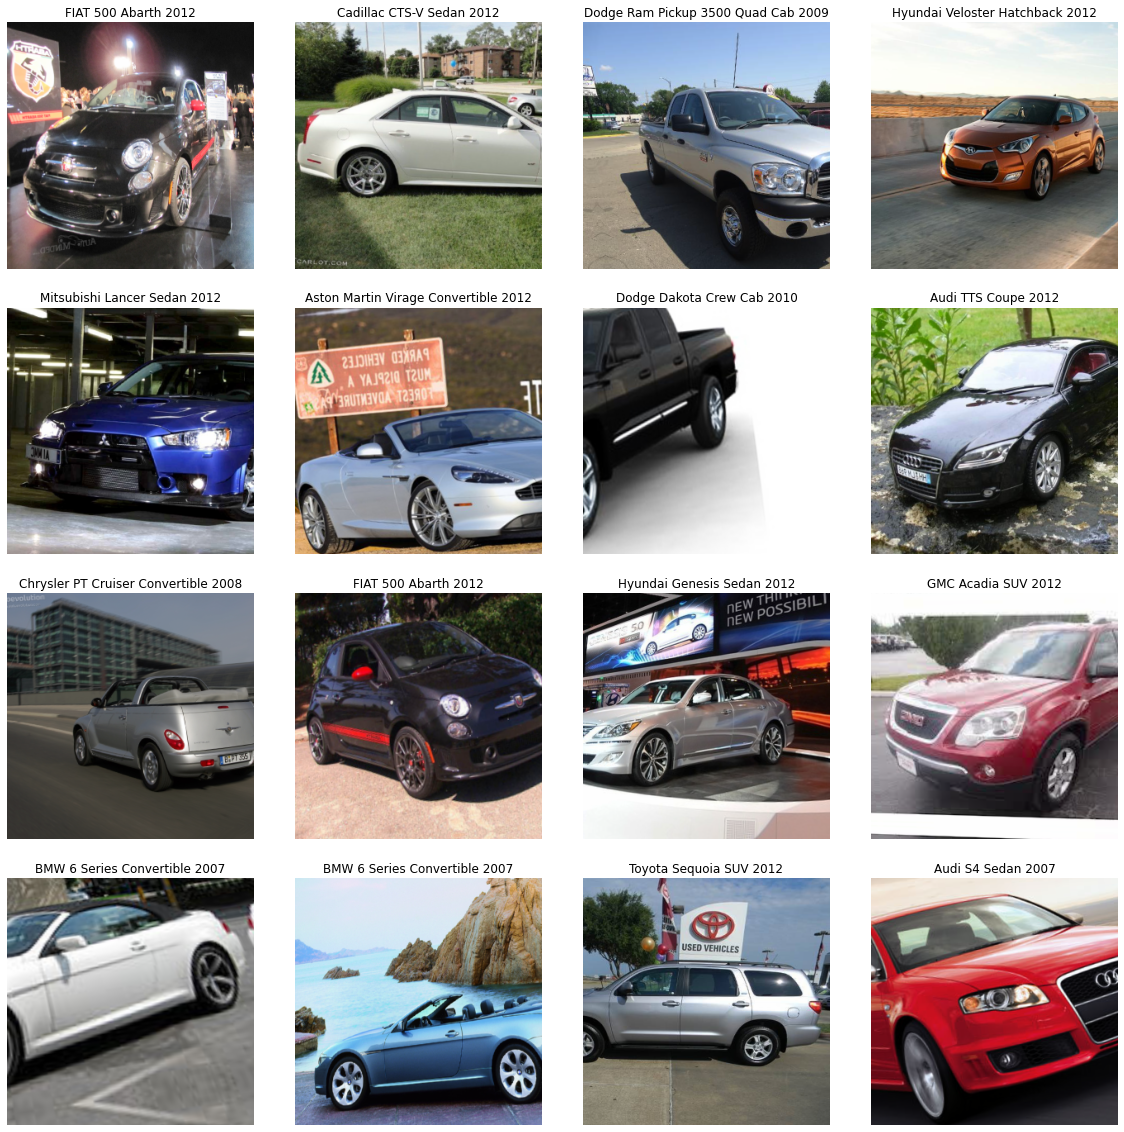

In [70]:
#Show image in a batch
data.show_batch()

concanteaning traing and testing dataframes

In [111]:
df1 = train_df
train_df['is_valid'] = False
df2 = test_df
test_df['is_valid'] = True
full_df = pd.concat([df1,df2])

In [112]:
full_df.head()

,fname,label,is_valid
0,00001.jpg,Audi TTS Coupe 2012,False
1,00002.jpg,Acura TL Sedan 2012,False
2,00003.jpg,Dodge Dakota Club Cab 2007,False
3,00004.jpg,Hyundai Sonata Hybrid Sedan 2012,False
4,00005.jpg,Ford F-450 Super Duty Crew Cab 2012,False


preparing test databunch

In [31]:
test_data = (ImageList.from_df(df=full_df, path=car_test)
            .split_from_df()
            .label_from_df(cols='label')
            .transform(tfms=tfms, size=size)
            .databunch(bs=bs)
            )

In [32]:
test_data

ImageDataBunch;

Train: LabelList (8144 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Audi TTS Coupe 2012,Acura TL Sedan 2012,Dodge Dakota Club Cab 2007,Hyundai Sonata Hybrid Sedan 2012,Ford F-450 Super Duty Crew Cab 2012
Path: /home/jupyter/.fastai/data/car/cars_test;

Valid: LabelList (8041 items)
x: ImageList
Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299),Image (3, 299, 299)
y: CategoryList
Suzuki Aerio Sedan 2007,Ferrari 458 Italia Convertible 2012,Jeep Patriot SUV 2012,Toyota Camry Sedan 2012,Tesla Model S Sedan 2012
Path: /home/jupyter/.fastai/data/car/cars_test;

Test: None

In [33]:
learn = cnn_learner(data, arch, metrics=metric)

In [34]:
learn.summary()

Sequential
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               [64, 150, 150]       9,408      False     
______________________________________________________________________
BatchNorm2d          [64, 150, 150]       128        True      
______________________________________________________________________
ReLU                 [64, 150, 150]       0          False     
______________________________________________________________________
MaxPool2d            [64, 75, 75]         0          False     
______________________________________________________________________
Conv2d               [64, 75, 75]         36,864     False     
______________________________________________________________________
BatchNorm2d          [64, 75, 75]         128        True      
______________________________________________________________________
ReLU                 [64, 75, 75]         0          False     
___________________________________________________

In [35]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


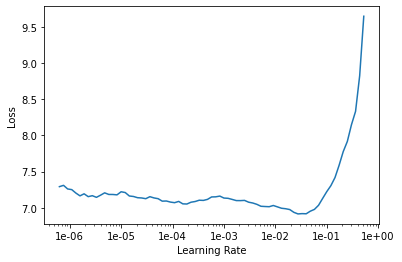

In [36]:
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(10, max_lr=slice(1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,6.495733,5.151697,0.035012,01:00
1,5.043696,3.852347,0.159705,00:56
2,3.889359,3.097129,0.268428,00:57
3,3.327320,2.578755,0.377764,00:57
4,2.831336,2.273445,0.431818,00:56
5,2.418607,2.067002,0.482187,00:57
6,2.159341,1.927238,0.526413,00:56
7,1.892485,1.856899,0.531327,00:57
8,1.841728,1.817070,0.548526,00:56
9,1.785176,1.826285,0.538084,00:56


In [38]:
learn.save('car-'+ arch_name +'-299px-5ep-1e-3')

In [39]:
learn.validate(test_data.valid_dl)

NameError: name 'test_data' is not defined

In [40]:
learn.unfreeze()

In [41]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


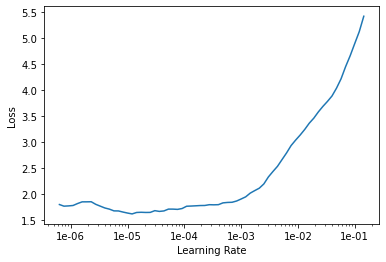

In [42]:
learn.recorder.plot()

In [43]:
learn.fit_one_cycle(10, max_lr=slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.718677,1.774458,0.554668,00:57
1,1.673519,1.655594,0.584152,00:58
2,1.524555,1.524351,0.610565,00:58
3,1.317580,1.440297,0.626536,00:57
4,1.312614,1.338213,0.657862,00:58
5,1.235864,1.262017,0.668919,00:57
6,1.062392,1.220909,0.676904,00:58
7,1.045175,1.185948,0.694717,00:58
8,0.977269,1.185643,0.694103,00:58
9,0.936792,1.193111,0.688575,00:58


In [44]:
learn.save('car-'+ arch_name +'-299-unfreeze-5ep-1e6-1e3')

In [ ]:
learn.validate(test_data.valid_dl)

## Add normalize imagenet stats

In [46]:
data_normalize = (
    ImageList.from_df(df=train_df, path=car_train)
    .split_by_rand_pct(valid_pct=.2, seed=1010)
    .label_from_df(cols='class_name')
    .transform(tfms=tfms, size=size)
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [47]:
test_data = (ImageList.from_df(df=full_df, path=car_test)
            .split_from_df()
            .label_from_df(cols='label')
            .transform(tfms=tfms, size=size)
            .databunch(bs=bs)
            .normalize(imagenet_stats)
            )

In [47]:
learn_normalize = cnn_learner(data, arch, metrics=metric)

In [48]:
learn_normalize.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


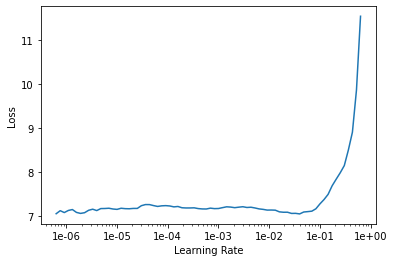

In [49]:
learn_normalize.recorder.plot()

In [50]:
learn_normalize.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.488008,5.179120,0.023342,00:56
1,4.909557,3.657563,0.179975,00:56
2,3.590494,2.636522,0.369779,00:56
3,2.881267,2.041574,0.486486,00:56
4,2.309452,1.733587,0.557125,00:56
5,1.954756,1.531005,0.609337,00:56
6,1.692151,1.401430,0.640049,00:56
7,1.459782,1.313300,0.660319,00:57
8,1.308603,1.279510,0.653563,00:57
9,1.361274,1.268562,0.658477,00:56


In [51]:
learn_normalize.save('car-'+ arch_name +'-normalize-299-5ep-1e-3')

In [53]:
#learn_normalize.validate(test_data.valid_dl)

In [54]:
learn_normalize.unfreeze()

In [55]:
learn_normalize.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


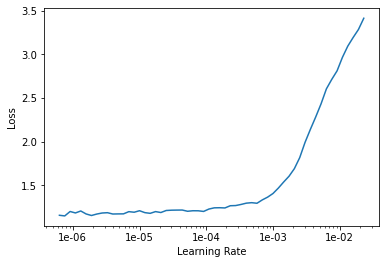

In [56]:
learn_normalize.recorder.plot()

In [57]:
learn_normalize.fit_one_cycle(10,max_lr=(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,1.281207,1.205266,0.685504,00:57
1,1.431585,1.271405,0.655405,00:58
2,1.399589,1.213565,0.682432,00:57
3,1.182527,1.077991,0.719902,00:57
4,0.935660,0.905903,0.761671,00:57
5,0.805611,0.772411,0.785627,00:58
6,0.543461,0.650975,0.828624,00:57
7,0.387621,0.610575,0.831081,00:58
8,0.338583,0.579595,0.835995,00:57
9,0.305233,0.562224,0.845209,00:58


In [58]:
#learn_normalize.validate(test_data.valid_dl)

In [59]:
learn_normalize.save('car-'+ arch_name +'-normalize-unfreeze-299-5ep-1e-4')

## Add resize_method=ResizeMethod.SQUISH to transform

In [ ]:
data_normalize_tfms = (
    ImageList.from_df(df=train_df, path=car_train)
    .split_by_rand_pct(valid_pct=.2, seed=1010)
    .label_from_df(cols='label')
    .transform(tfms=tfms, size=size, resize_method=ResizeMethod.SQUISH, padding_mode='reflection')
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [61]:
learn_normalize_tfms=cnn_learner(data_normalize, arch, metrics=metric )

In [62]:
learn_normalize_tfms.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


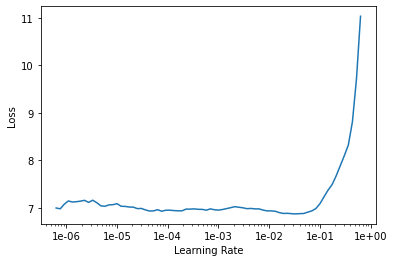

In [63]:
learn_normalize_tfms.recorder.plot()

In [64]:
learn_normalize_tfms.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.451786,5.218964,0.025799,00:53
1,4.874170,3.607010,0.195946,00:54
2,3.659047,2.670710,0.358722,00:53
3,2.892349,2.072608,0.492015,00:53
4,2.390443,1.784001,0.545455,00:54
5,1.997750,1.502814,0.619779,00:54
6,1.668240,1.336137,0.648034,00:52
7,1.409380,1.281133,0.669533,00:52
8,1.386396,1.238152,0.678747,00:53
9,1.220783,1.244906,0.686118,00:53


In [65]:
learn_normalize_tfms.validate(test_data.valid_dl)

[1.2585366, tensor(0.6834)]

In [66]:
learn_normalize_tfms.save('car-'+ arch_name +'-normalize-tfms-299-5ep-1e-4')

In [67]:
learn_normalize_tfms.unfreeze()

In [68]:
learn_normalize_tfms.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


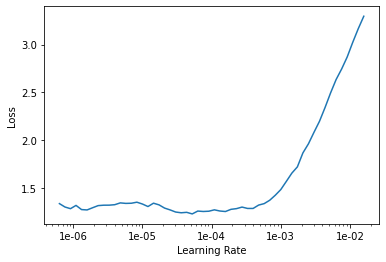

In [69]:
learn_normalize_tfms.recorder.plot()

In [70]:
learn_normalize_tfms.fit_one_cycle(10,max_lr=1e-4)

epoch,train_loss,valid_loss,accuracy,time
0,1.291840,1.182541,0.692260,00:55
1,1.455989,1.203883,0.675676,00:54
2,1.461153,1.155914,0.701474,00:54
3,1.209588,1.035992,0.732801,00:54
4,0.956165,0.851540,0.772727,00:53
5,0.736147,0.714870,0.818182,00:54
6,0.520654,0.648015,0.813882,00:53
7,0.444281,0.592276,0.840909,00:54
8,0.321118,0.561316,0.839681,00:54
9,0.312025,0.562682,0.842752,00:53


In [71]:
learn_normalize_tfms.validate(test_data.valid_dl)

[0.54715395, tensor(0.8537)]

In [72]:
learn_normalize_tfms.save('car-'+ arch_name +'-normalize-tfms-unfreeze-299-5ep-1e-4')

## Add Mixup to learner

In [73]:
data_normalize_mixup = (
    ImageList.from_df(df=train_df, path=car_train)
    .split_by_rand_pct(valid_pct=.2, seed=1010)
    .label_from_df(cols='label')
    .transform(tfms=tfms, size=size )
    .databunch(bs=bs)
    .normalize(imagenet_stats)
)

In [74]:
learn_normalize_tfms_mixup=cnn_learner(data_normalize_mixup, arch, metrics=metric).mixup()

In [75]:
learn_normalize_tfms_mixup.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


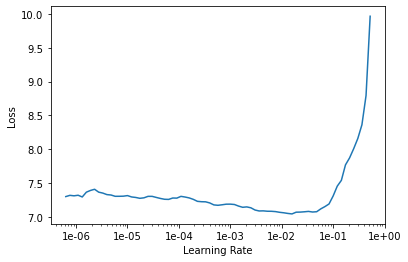

In [76]:
learn_normalize_tfms_mixup.recorder.plot()

In [77]:
learn_normalize_tfms_mixup.fit_one_cycle(10, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,6.690841,5.286168,0.019656,00:53
1,5.456529,3.962509,0.151720,00:53
2,4.538407,3.003801,0.293612,00:53
3,3.993457,2.402852,0.414619,00:52
4,3.572528,2.153713,0.482187,00:51
5,3.286595,1.872282,0.539926,00:52
6,3.049185,1.708200,0.592752,00:52
7,2.987592,1.606643,0.618550,00:52
8,2.849090,1.571249,0.628993,00:52
9,2.788570,1.581038,0.632678,00:52


In [78]:
learn_normalize_tfms_mixup.save('car-'+ arch_name +'-normalize-mixup-299-5ep-1e-4')

In [79]:
learn_normalize_tfms_mixup.unfreeze()

In [80]:
learn_normalize_tfms_mixup.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


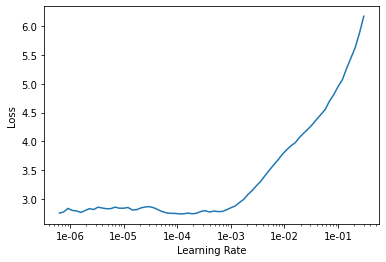

In [81]:
learn_normalize_tfms_mixup.recorder.plot()

In [82]:
learn_normalize_tfms_mixup.fit_one_cycle(10, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,2.776842,1.523612,0.635749,00:54
1,2.730743,1.491626,0.648649,00:53
2,2.664272,1.412362,0.662162,00:53
3,2.614305,1.334348,0.683047,00:53
4,2.538263,1.263373,0.705774,00:53
5,2.448564,1.216685,0.704545,00:54
6,2.402991,1.180773,0.715602,00:54
7,2.365962,1.164296,0.726044,00:54
8,2.355587,1.136764,0.727887,00:53
9,2.339696,1.143211,0.731573,00:54


In [83]:
learn_normalize_tfms_mixup.save('car-'+ arch_name +'-normalize-mixup-unfreeze-299-5ep-1e-4')

In [84]:
learn_normalize_tfms_mixup.validate(test_data.valid_dl)

[1.1332439, tensor(0.7339)]